<a href="https://colab.research.google.com/github/Gaussiandra/NTA_Landmarks_Detection/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Jun  4 13:20:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Импорт библиотек

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rx0mgam6
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rx0mgam6
     |████████████████████████████████| 634kB 11.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=2d55868cb49071270f79fc4ea4fe03f0a0b15120660666e9ed1f0889a0259479
  Stored in directory: /tmp/pip-ephem-wheel-cache-uaz5l37q/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1dbe63276d63856787cb7d5e75e5a75403b0a5187070e41f11ecc034746c6c13
  Stored in directory: /tmp/pip-ephem-wheel-cache-uaz5l37q/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albu

In [0]:
import os
import cv2
import gc
import time
import random
import pickle
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn import functional as fnn
from torchvision import transforms

## Параметры

In [0]:
NUM_PTS = 194
CROP_SIZE = 160
BATCH_SIZE = 64

In [0]:
SEED = 3462

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

global_path = '/content/drive/My Drive/ML/NTA Landmarks Detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TEST_PATH = global_path+"data/baseline_NTA/data/test/" 
TRAIN_PATH = global_path+"data/baseline_NTA/data/train/"
SUBMISSION_PATH = global_path+"data/baseline_NTA/data/train/"
LANDMARKS = global_path+"data/baseline_NTA/data/train/landmarks.csv"

SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

In [9]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.max_memory_allocated(device='cuda'))
print(torch.cuda.empty_cache())

1.5.0+cu101
10.1
7603
True
1
0
None


In [0]:
class LandmarksDataset(Dataset):
    def __init__(self, root, init_augmentations, split, train_augm=None, test_augm=None):
        assert split in ('train', 'test')

        super(LandmarksDataset, self).__init__()
        self.root = root
        self.init_augmentations = init_augmentations
        self.split = split
        self.train_augm = train_augm
        self.test_augm = test_augm

        file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
        images_root = os.path.join(root, "images")

        self.samples = []

        with open(file_name, "rt") as fp:
            for i, line in tqdm(enumerate(fp), total=len(os.listdir(images_root))):
                if i == 0:
                    continue  # skip header

                elements = line.strip().split(",")
                image_name = os.path.join(images_root, elements[0])
                cur_img = cv2.imread(image_name)
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

                if split == "train":
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                else:
                    landmarks = []

                augmented_data = init_augmentations(image=cur_img, keypoints=landmarks)
                cur_sample = {
                    'x_init_resolution': cur_img.shape[1],
                    'y_init_resolution': cur_img.shape[0],
                    'image': augmented_data['image'],
                    'keypoints': augmented_data['keypoints']
                }

                self.samples.append(cur_sample)

    def get_box(self, keypoints, bound=40):
        x_min = int(round(min(map(lambda x: x[0], keypoints))))
        x_max = int(round(max(map(lambda x: x[0], keypoints))))
        y_min = int(round(min(map(lambda x: x[1], keypoints))))
        y_max = int(round(max(map(lambda x: x[1], keypoints))))

        return (
            max(0, x_min-bound),
            max(0, y_min-bound),
            min(2*CROP_SIZE, x_max+bound),
            min(2*CROP_SIZE, y_max+bound)
        )
    
    def __getitem__(self, idx):
        cur_sample = dict(self.samples[idx])

        if self.split == 'train':
            augmented_data = self.train_augm(
                cropping_bbox=self.get_box(cur_sample['keypoints']),
                **cur_sample
            )
            
            cur_sample['image'] = augmented_data['image']
            cur_sample['keypoints'] = np.array(augmented_data['keypoints'])
            return cur_sample
        else:
            return self.test_augm(**cur_sample)

    def __len__(self):
        return len(self.samples)

In [0]:
# Корректный флип точек нагло скопирован из ods
# https://opendatascience.slack.com/archives/CGHGA0DQC/p1591103022218100?thread_ts=1591101465.217800&cid=CGHGA0DQC

keypoint_reflection_indexes = [
    [slice(0, 21), slice(40, 19, -1)],
    [slice(41, 50), slice(57, 48, -1)],
    [slice(58, 65), slice(71, 64, -1)],
    [slice(72, 79), slice(85, 78, -1)],
    [slice(86, 93), slice(99, 92, -1)],
    [slice(100, 107), slice(113, 106, -1)],
    [slice(114, 134), slice(134, 154)],
    [slice(154, 174), slice(174, 194)]
]

def reflect_keypoints(keypoints):
    new_keypoints = deepcopy(keypoints)
    for slice1, slice2 in keypoint_reflection_indexes:
        new_keypoints[slice1] = keypoints[slice2]
        new_keypoints[slice2] = keypoints[slice1]
    return new_keypoints

class CustomHorizontalFlip(albu.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints = reflect_keypoints(keypoints)
        return super().apply_to_keypoints(keypoints, **params)

class CustomCoarseDropout(albu.CoarseDropout):
    def apply(self, image, fill_value=0, holes=(), **params):
        return albu.augmentations.functional.cutout(image, holes, image.mean())

init_augm = albu.Compose([
    albu.LongestMaxSize(2*CROP_SIZE),
    albu.PadIfNeeded(2*CROP_SIZE, 2*CROP_SIZE, 1),                  
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

train_augm = albu.Compose([
    albu.IAAPerspective((0, 0.04), p=0.5),
    albu.RandomCropNearBBox(0.07, p=0.33),
    CustomHorizontalFlip(p=0.5),
    albu.Rotate(30, p=0.5),
    albu.Resize(CROP_SIZE, CROP_SIZE),

    albu.RGBShift(0.02, 0.02, 0.02, p=0.5),
    albu.HueSaturationValue(10, 20, 10, p=0.5),
    albu.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    albu.CLAHE(2, p=0.5),
    albu.MedianBlur(4, p=0.1),
    albu.ToGray(p=0.1),
    albu.IAASharpen(p=0.5),
    CustomCoarseDropout(64, 10, 10, p=0.5),

    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

test_augm = albu.Compose([
    albu.Resize(CROP_SIZE, CROP_SIZE),
    albu.Normalize()
])

In [0]:
#whole_dataset = LandmarksDataset(os.path.join(TRAIN_PATH), init_augm, "train", train_augm=train_augm)
#test_dataset = LandmarksDataset(os.path.join(TEST_PATH), init_augm, "test", test_augm=test_augm)
#pickle.dump(whole_dataset, open(global_path+'whole_ds.pkl', 'wb'))
#pickle.dump(test_dataset, open(global_path+'test_ds.pkl', 'wb'))

In [0]:
whole_dataset = pickle.load(open(global_path+'whole_ds.pkl', 'rb'))
test_dataset = pickle.load(open(global_path+'test_ds.pkl', 'rb'))

In [0]:
whole_dataset.train_augm = train_augm
test_dataset.test_augm = test_augm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


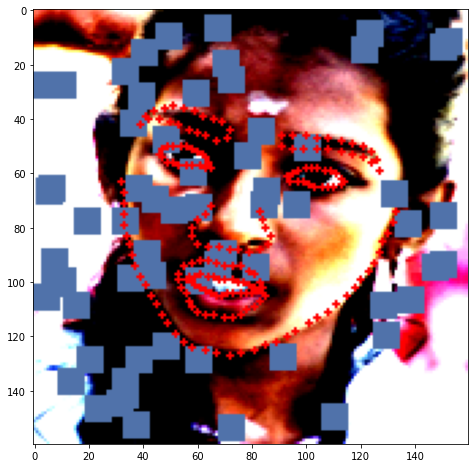

In [0]:
augm_img = whole_dataset[54]
vis_points(augm_img['image'], augm_img['keypoints'], diameter=1)
plt.show()

In [0]:
torch.manual_seed(SEED)

from torch.utils.data import random_split
train_size = int(0.9 * len(whole_dataset))
val_size = len(whole_dataset) - train_size
train_dataset, val_dataset = random_split(whole_dataset, [train_size, val_size])

In [0]:
train_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
#val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [0]:
def vis_points(image, points, diameter=15, rec_coords=None):
    im = image.copy()
    
    if rec_coords:
        cv2.rectangle(im, (rec_coords[0], rec_coords[1]), (rec_coords[2], rec_coords[3]),
                      (255, 0, 0), thickness=diameter)
    for i, (x, y) in enumerate(points):
        cv2.circle(im, (int(x), int(y)), diameter, (255, 0, 0), -1)
        #cv2.putText(im,
        #            str(i),
        #            (int(x), int(y)),
        #            cv2.FONT_HERSHEY_COMPLEX_SMALL, 
        #            2,
        #            (255, 0, 0),
        #            2)

    plt.figure(figsize=(8, 8))
    plt.imshow(im)

In [0]:
landmark_csv = pd.read_csv(os.path.join(TRAIN_PATH, 'landmarks.csv'), index_col='filename')

In [0]:
chf = albu.Compose([
    CustomHorizontalFlip(p=0)
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

In [0]:
images_root = os.path.join(TRAIN_PATH, "images")
image_name = '2941961941_1.jpg'

cur_img = cv2.imread(os.path.join(images_root, image_name))
cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

landmarks = list(map(np.int16, landmark_csv.loc[image_name].values))
landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))

augm_img = chf(image=cur_img, keypoints=landmarks)
vis_points(augm_img['image'], augm_img['keypoints'], diameter=5)
plt.show()

In [0]:
gc.collect()

866

In [16]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 12.7MB/s 


In [17]:
from facenet_pytorch import InceptionResnetV1
vggface2 = InceptionResnetV1(pretrained='vggface2')

In [18]:
model = nn.Sequential(
    nn.Sequential(*list(vggface2.children())[:-4]),
    nn.Conv2d(1792, 2*NUM_PTS, 1),
    nn.MaxPool2d(1, 1),
    nn.Flatten(),
    #nn.BatchNorm1d(2*NUM_PTS),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.03),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
loss_fn = fnn.mse_loss

cur_iter = 0

model(torch.randn(4, 3, 160, 160).to(device)).shape

torch.Size([4, 388])

In [0]:
# Другой facenet, больше аугментаций, нормальная архитектура, статеечки, лайфхаки по аугментациям
# Последняя сввёртка -- выкинуть или заменить нормальными
# GAN augment
# catboost поверх 
# Работа с фото с самыми высокими ошибками, hard negatives mining?
# Клиппинг предсказанны координат
# Усреднять значения для теста на аугментации
# Усреднять веса с лучших точек
# погуглить про pseudolabeling

In [0]:
#!rm -rf '/content/drive/My Drive/ML/TG_DL/10/tensorboard/'

In [0]:
model_name = 'vggface2_cut-4 full ds_'

In [19]:
last_checkpoint = torch.load(
    global_path+"vggface2_cut-4 full ds_4332_whole ds.tar",
    map_location=device
)

model.load_state_dict(last_checkpoint['model'], strict=False)
optimizer.load_state_dict(last_checkpoint['optim'])
cur_iter = last_checkpoint['n_iters']

cur_iter

4332

In [0]:
import tensorflow as tf
%load_ext tensorboard

In [0]:
tb_path = global_path+'tensorboard/'
train_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_train')
val_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_val')

In [29]:
%tensorboard --logdir '/content/drive/My Drive/ML/NTA Landmarks Detection/tensorboard/'

<IPython.core.display.Javascript object>

In [28]:
#cur_batch, cur_loss = 0, 0

for e in range(50):
    for batch in tqdm(train_iter, desc=str(f'{e}_{cur_iter}')):
        model.train()
        optimizer.zero_grad()

        images = batch['image'].permute([0, 3, 1, 2]).to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)  # B x (2 * NUM_PTS)

        pred_landmarks = model(images)  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks)

        #cur_batch = batch
        #cur_loss = loss
        #break

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.item(), step=cur_iter)

        loss.backward()
        optimizer.step()

        if cur_iter % 105894637 == 0:
            model.eval()

            for batch in val_iter:
                images = batch['image'].permute([0, 3, 1, 2]).to(device)
                landmarks =  batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

                with torch.no_grad():
                    pred_landmarks = model(images)
                loss = loss_fn(pred_landmarks, landmarks, reduction="mean")

                with val_summary_writer.as_default():
                    tf.summary.scalar('loss', loss.item(), step=cur_iter)

                break # Написать по-нормальному

        cur_iter += 1

KeyboardInterrupt: ignored

In [0]:
cur_loss.mean(dim=1)

tensor([ 40.8855,  25.1114,  16.3466,  37.7959,  13.2069,  29.5044,  27.0266,
         15.5636,  42.6003,  14.8781,  13.4537,  10.6374,  48.5106,  19.3116,
         54.4611,  25.2862,  75.4487,  38.1045,  46.0629,  23.1780,   7.8896,
         16.7213,  14.2523,   8.7577,  46.7914,  11.1253,  27.5833,  19.6208,
         21.2526,  13.3969,  45.4727,  17.9864,  12.6516,  30.7182,  42.4487,
         82.7100,  21.1748,  28.1335,  14.3864,  26.9864,  18.1488,  33.8286,
         46.0660,  24.1931,  31.2215,  17.8553,  12.2650,  37.9930,  21.2936,
         37.0408,  90.8841,  18.9231,  29.6094,   7.0865,  13.4773,  53.5893,
         25.1606,  27.5593,  44.0354,  23.1418,   7.9746,  18.1395, 232.1920,
         24.8499], device='cuda:0', grad_fn=<MeanBackward1>)

In [0]:
cur_loss.mean(dim=1).argsort(descending=True)

tensor([62, 50, 35, 16, 14, 55, 12, 24, 42, 18, 30, 58,  8, 34,  0, 17, 47,  3,
        49, 41, 44, 33, 52,  5, 37, 26, 57,  6, 39, 15, 56,  1, 63, 43, 19, 59,
        48, 28, 36, 27, 13, 51, 40, 61, 31, 45, 21,  2,  7,  9, 38, 22, 54, 10,
        29,  4, 32, 46, 25, 11, 23, 60, 20, 53], device='cuda:0')

In [0]:
sorted(cur_loss.mean(dim=1), reverse=True)

[tensor(232.1920, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(90.8841, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(82.7100, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(75.4487, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(54.4611, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(53.5893, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(48.5106, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(46.7914, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(46.0660, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(46.0629, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(45.4727, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(44.0354, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(42.6003, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(42.4487, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(40.8855, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(38.1045, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(37.9930, device

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


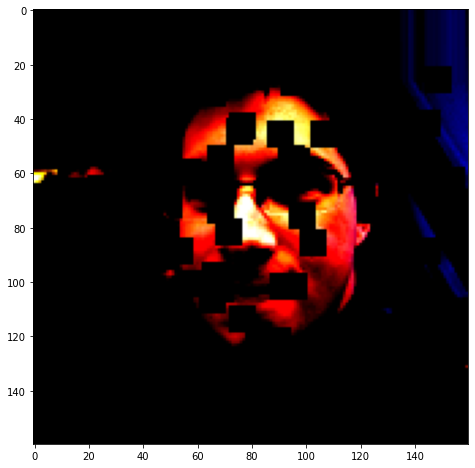

In [0]:
vis_points(np.array(cur_batch['image'][_432[8]]), [], 2)

In [30]:
save_path = f'{global_path}{model_name}_{cur_iter}_whole ds.tar'
assert not os.path.exists(save_path)
torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'n_iters': cur_iter
        }, save_path)      

print(save_path)

/content/drive/My Drive/ML/NTA Landmarks Detection/vggface2_cut-4 full ds__5150_whole ds.tar


In [31]:
losses = []

########!!!!
val_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
model.eval()
for batch in val_iter:
    images = batch['image'].permute([0, 3, 1, 2]).to(device)
    landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
    losses.append(loss.item())
print(np.mean(losses), np.std(losses))

6.602810919284821 0.7511526303303311


In [0]:
def shift_augm_landmark(init_resolution, landmarks):
    points = torch.tensor(landmarks) 

    scale_factor = max(init_resolution) / CROP_SIZE
    x_margin = (CROP_SIZE - init_resolution[0] / scale_factor) / 2
    y_margin = (CROP_SIZE - init_resolution[1] / scale_factor) / 2
    margin_pair = np.array([x_margin, y_margin])

    handle_pair = lambda x: (x - margin_pair) * scale_factor
    return list(map(handle_pair, points))
    
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    
    cur_str = 0
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch['image'].permute([0, 3, 1, 2]).to(device) 

        with torch.no_grad():
            pred_landmarks = model(images).cpu().numpy()  # B x NUM_PTS x 2

        for j in range(len(batch['x_init_resolution'])):
            hz = shift_augm_landmark((batch['x_init_resolution'][j], batch['y_init_resolution'][j]), pred_landmarks[j].reshape(NUM_PTS, 2))
            hz = np.array(list(map(lambda x: np.array(x), hz)))

            predictions[cur_str] = hz
            cur_str += 1

    return predictions

def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data)

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter=',')
    
    for i, row in mapping.iterrows():   
        file_name = row[0]

        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [33]:
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_predictions = predict(model, test_iter, device)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
create_submission(TEST_PATH, test_predictions, "submit.csv")

---

In [0]:
def get_orig_img(path, split, index):
    root = path
    file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
    images_root = os.path.join(root, "images")

    with open(file_name, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            image_name = os.path.join(images_root, elements[0])
            cur_img = cv2.imread(image_name)
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

            return cur_img

def coords_from_sumb_file(path, index):
    with open(path, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            return np.array(list(map(int, elements[1:])))
            
def landmarks2pairs(points):
    x_coords = np.array(points[::2], dtype=np.uint8)
    y_coords = np.array(points[1::2], dtype=np.uint8)

    return list(zip(x_coords, y_coords))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


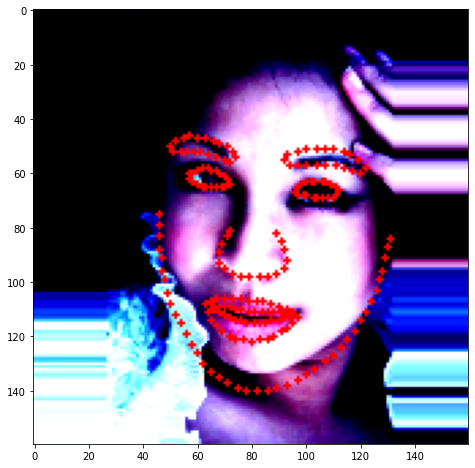

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


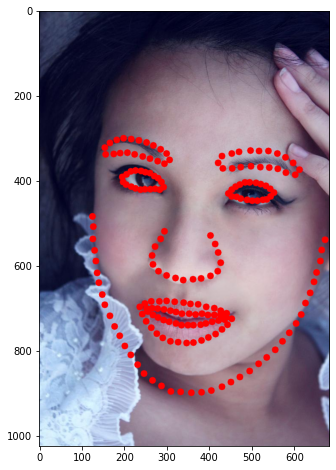

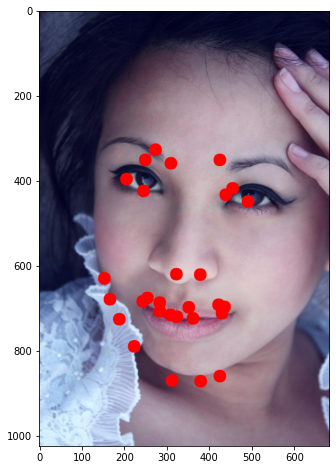

In [39]:
cur_img, cur_predictions, id = 0, 0, np.random.randint(64)

model.eval()
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
for i, data in enumerate(test_iter):
    cur_img = data['image'].permute([0, 3, 1, 2])[id].unsqueeze(dim=0).to(device)
    cur_predictions = model(cur_img).cpu().detach()
    break

vis_points(test_dataset[id]['image'], landmarks2pairs(cur_predictions[0]), diameter=1)
plt.show()

cur_orig_img = get_orig_img(TEST_PATH, 'test', id)
shifted_preds = shift_augm_landmark((test_dataset[id]['x_init_resolution'], test_dataset[id]['y_init_resolution']), cur_predictions[0].reshape(194, 2))
vis_points(cur_orig_img, shifted_preds, 8)
plt.show()

vis_points(cur_orig_img, coords_from_sumb_file("submit.csv", id).reshape(-1, 2))

---